https://drive.google.com/file/d/157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB/view -dataset link

#Importin

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
from torchvision import models
import os
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


#Hist and data loader

In [ ]:
def hisEqulColor(img):
    ycrcb=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
    channels=cv2.split(ycrcb)
    cv2.equalizeHist(channels[0],channels[0])
    cv2.merge(channels,ycrcb)
    cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2BGR,img)
    return img

In [ ]:
x_train = []
for f in sorted(os.listdir("/content/drive/MyDrive/LOLdataset/our485/low/")):
  path = "/content/drive/MyDrive/LOLdataset/our485/low/"+f
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  c = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  col = hisEqulColor(img)
  col = cv2.cvtColor(col, cv2.COLOR_BGR2RGB)
  t= torch.tensor(col)
  t=t.float()
  t = t.reshape(3,400,600)
  x_train.append(t)

In [ ]:
y_train = []
for f in sorted(os.listdir("/content/drive/MyDrive/LOLdataset/our485/high/")):
  path = "/content/drive/MyDrive/LOLdataset/our485/high/"+f
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  c = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  t= torch.tensor(c)
  t=t.float()
  t = t.reshape(3,400,600)
  t.to("cuda:0")
  y_train.append(t)

In [ ]:
X_train_tensor = torch.stack(x_train, dim=0)
Y_train_tensor = torch.stack(y_train, dim=0)


In [ ]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

In [ ]:
batch_size = 8  # You can change this value
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

#Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5,padding=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=3)
        self.rel = nn.ReLU()
        self.float()


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv4(x)
        x = self.rel(x)
        return x

In [ ]:
model = CNN()
model.to("cuda:0")

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1))
  (rel): ReLU()
)

In [ ]:
summary(model, (3,400,600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 402, 602]           4,864
            Conv2d-2        [-1, 128, 402, 602]         204,928
            Conv2d-3          [-1, 3, 400, 600]           3,459
              ReLU-4          [-1, 3, 400, 600]               0
Total params: 213,251
Trainable params: 213,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.75
Forward/backward pass size (MB): 365.48
Params size (MB): 0.81
Estimated Total Size (MB): 369.04
----------------------------------------------------------------


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10):
    for X_batch, Y_batch in train_loader:
      optimizer.zero_grad()  # Zero the parameter gradients
      X_batch = X_batch.to("cuda:0")
      Y_batch = Y_batch.to("cuda:0")
      # Forward pass
      enhanced_imgs = model(X_batch)
      loss = criterion(enhanced_imgs, Y_batch)

      # Backward pass and optimize
      loss.backward()
      optimizer.step()
    print(epoch,loss)

0 tensor(1904.6708, device='cuda:0', grad_fn=<MseLossBackward0>)
1 tensor(2180.4739, device='cuda:0', grad_fn=<MseLossBackward0>)
2 tensor(1712.0841, device='cuda:0', grad_fn=<MseLossBackward0>)
3 tensor(1363.4138, device='cuda:0', grad_fn=<MseLossBackward0>)
4 tensor(1264.8260, device='cuda:0', grad_fn=<MseLossBackward0>)
5 tensor(2168.8196, device='cuda:0', grad_fn=<MseLossBackward0>)
6 tensor(808.4228, device='cuda:0', grad_fn=<MseLossBackward0>)
7 tensor(1688.6534, device='cuda:0', grad_fn=<MseLossBackward0>)
8 tensor(2555.0452, device='cuda:0', grad_fn=<MseLossBackward0>)
9 tensor(1052.9398, device='cuda:0', grad_fn=<MseLossBackward0>)


#Testing

In [ ]:
path = "/content/myimage_504.jpg"
img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
low = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
col = hisEqulColor(img)
col = cv2.cvtColor(col, cv2.COLOR_BGR2RGB)
t= torch.tensor(col)
t=t.float()
t = t.reshape(-1,3,400,600)

In [ ]:
t.shape

torch.Size([1, 3, 400, 600])

In [ ]:
t = t.to("cuda:0")
f = model.forward(t)
print(f.max())
f=f.reshape(400,600,3)
f=f.clip(max=255)
f=f.int()
print(f.shape)
f_im = f.cpu().detach().numpy()

tensor(283.8566, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([400, 600, 3])


In [ ]:
path = "/content/myimage_505.jpg"
img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
c = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

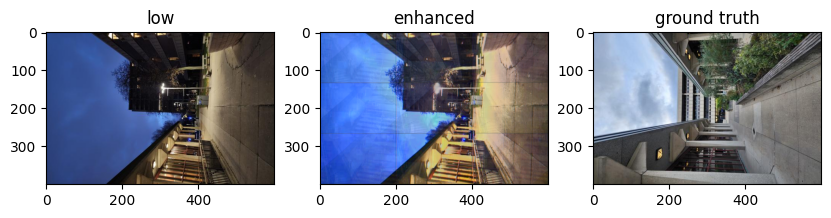

In [ ]:


fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (10,6))

axes[0].imshow(low)
axes[1].imshow(f_im)
axes[2].imshow(c)
axes[0].set_title("low")
axes[1].set_title("enhanced")
axes[2].set_title("ground truth")

plt.show()

In [ ]:
path = "/content/myimage_501.jpg"
img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

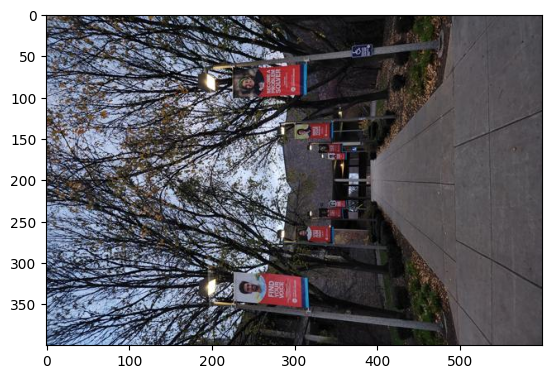

In [ ]:
plt.imshow(img)

In [ ]:
img.shape

(600, 400, 3)

In [ ]:
type(img)

numpy.ndarray

In [ ]:
a = img.resize((400,600,3))

ValueError: ignored

In [ ]:
from PIL import Image


In [ ]:
image = Image.open("/content/20231124_150630.jpg")


In [ ]:
new_image = image.resize((600, 400))

In [ ]:
new_image.size

(600, 400)

In [ ]:
new_image.save('myimage_505.jpg')
